# How does other products represent terrestrial carbon flux responses to a changing climate?

Trend analysis


In [1]:
import sys
import folium
import warnings
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import xarray as xr
import numpy as np
import contextily as ctx

import matplotlib.pyplot as plt

import odc.geo.xr
from odc.geo.geobox import zoom_out
from odc.geo.xr import assign_crs

sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

In [2]:
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from dask_utils import start_local_dask

client = start_local_dask(mem_safety_margin='2Gb')
client

distributed.nanny.memory - WARNING - Ignoring provided memory limit 200472325120 due to system memory limit of 46.00 GiB


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35823,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:34179,Total threads: 12
Dashboard: /proxy/35113/status,Memory: 46.00 GiB
Nanny: tcp://127.0.0.1:38801,


## Analysis Parameters

Start with 5km resolution datasets to speed up exploration

In [3]:

chunks=None#dict(latitude=250, longitude=250, time=1)

#SE AUS
# lat_bounds = slice(355, 590)
# lon_bounds = slice(575,840)

#All of Aus
lat_bounds = slice(0, 680)
lon_bounds = slice(0,840)

## Open data

In [4]:
modis_gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/MODIS_GPP_1km_monthly_2002_2021.nc')
modis_gpp.attrs['nodata'] = np.nan

gosif_gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/GOSIF_GPP_5km_monthly_2002_2021.nc')
gosif_gpp.attrs['nodata'] = np.nan


## Reproject

In [15]:
# grid = zoom_out(ds.odc.geobox, 5)
modis_gpp = modis_gpp.chunk(dict(latitude=1000,longitude=1000, time=1)).odc.reproject(how=gosif_gpp.odc.geobox,
                      resampling='average').compute()

modis_gpp = modis_gpp * 1000

## Linear Trends

In [10]:
import dask.array as da
from dask.delayed import delayed
from  scipy import stats

def _calc_slope(y):
    """return linear regression statistical variables"""
    mask = np.isfinite(y)
    x = np.arange(len(y))
    return stats.linregress(x[mask], y[mask])

# regression function defition
def regression(y):
    """apply linear regression function along time axis"""
    axis_num = y.get_axis_num('time')
    return da.apply_along_axis(_calc_slope, axis_num, y)

def linregress(ds):

    # fill pixels that are all-NaNs
    allnans = ds.isnull().all('time')
    ds = ds.where(~allnans, other=0)

    # regression analysis
    delayed_objs = delayed(regression)(ds).persist()

    # transforms dask.delayed to dask.array
    results = da.from_delayed(delayed_objs, shape=(5, ds.shape[1:][0], ds.shape[1:][1]), dtype=np.float32)
    results = results.compute()
    results = results.compute() #need this twice haven't figured out why

    # statistical variables definition
    variables = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']

    # coordination definition
    coords = {'latitude': ds.latitude, 'longitude': ds.longitude}

    # output xarray.Dataset definition
    ds_out = xr.Dataset(
        data_vars=dict(slope=(["latitude", "longitude"], results[0]),
                       intercept=(["latitude", "longitude"], results[1]),
                       r_value=(["latitude", "longitude"], results[2]),
                       p_value=(["latitude", "longitude"], results[3]),
                       std_err=(["latitude", "longitude"], results[4]),
                      ),
        coords = coords)

    #remask all-NaN pixel
    return ds_out.where(~allnans)


### Calculate trend in the annual series

In [78]:
warnings.filterwarnings("ignore")
modis_trend = linregress(modis_gpp.sel(time=slice('2003', '2021')).resample(time='1Y').mean())
gosif_trend = linregress(gosif_gpp.sel(time=slice('2003', '2021')).resample(time='1Y').mean())


/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python3110/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python3110/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python3110/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python3110/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python3110/l

### Plot

In [79]:
# et_trend.where(er_trend.p_value < 0.1).slope.plot.imshow(cmap='RdBu', robust=True, size=10)

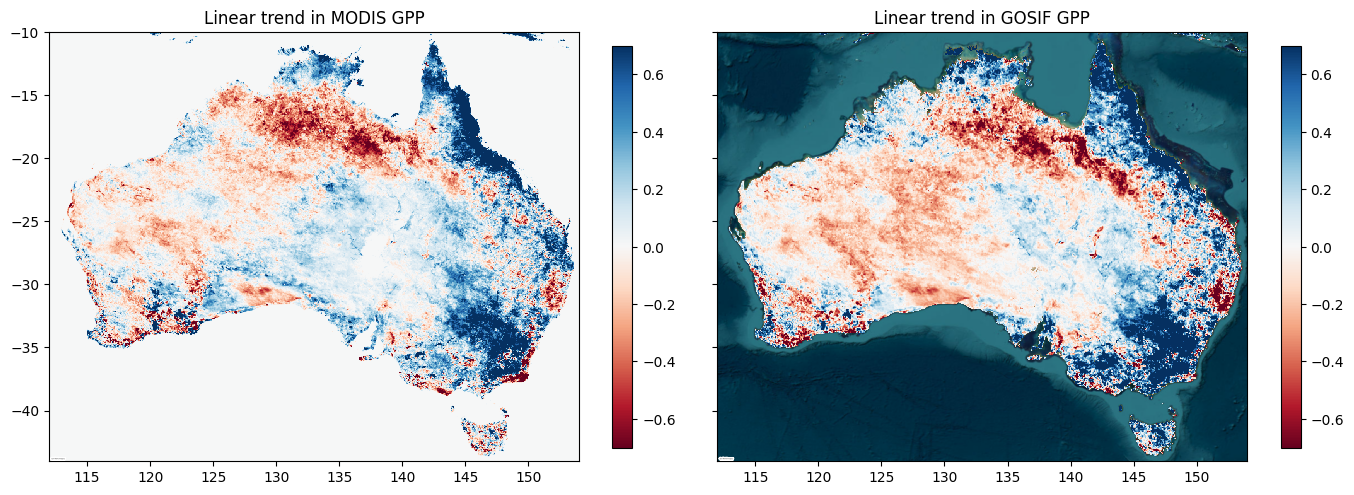

In [80]:
fig,ax = plt.subplots(1,2, figsize=(14,7), sharex=True, sharey=True)

vmax=0.7
vmin=-0.7

im = modis_trend.slope.plot(cmap='RdBu', vmax=vmax,vmin=vmin, ax=ax[0], add_colorbar=False, add_labels=False) #vmax=0.75, vmin=-0.75,
cbar = plt.colorbar(im, ax=ax[0], shrink=0.6)
ax[0].set_title('Linear trend in MODIS GPP')
ctx.add_basemap(ax[0], source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='Esri World Imagery', attribution_size=1)

im1 = gosif_trend.slope.plot(cmap='RdBu', vmax=vmax,vmin=vmin, ax=ax[1], add_colorbar=False, add_labels=False)
cbar = plt.colorbar(im1, ax=ax[1], shrink=0.6)
ax[1].set_title('Linear trend in GOSIF GPP')
ctx.add_basemap(ax[1], source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='Esri World Imagery', attribution_size=1)

plt.tight_layout();
plt.savefig('/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/MODIS_GOSIF_GPP_linear_trends.png', bbox_inches='tight')

## Plot extent on interactive map

In [81]:
m = folium.Map(control_scale = True)

# gpp_trend.where(gpp_trend.p_value<0.1).slope.odc.add_to(m, robust=True, cmap='RdBu')
gosif_trend.slope.odc.add_to(m, vmax=1.0, vmin=-1.0, cmap='RdBu')

# Zoom map to Australia
m.fit_bounds(gosif_trend.odc.map_bounds())

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
       ).add_to(m)

folium.LayerControl().add_to(m)
display(m)